# Verifica della legge dell'inverso del quadrato per l'intensità luminosa

## Motivazione

Data una sorgente luminosa puntiforme $S$, la teoria fornisce il valore dell'intensità luminosa $I$ in un punto $P$ a distanza $r=\overline{PS}$ dalla sorgente attraverso la relazione $$I=\frac{P}{4\pi r^2}\propto \frac{1}{r^2},$$
dove $P=\frac{\delta E}{\delta t}$ è la potenza erogata dalla sorgente.

Si vuole verificare sperimentalmente la dipendenza dell'intensità luminosa dall'inverso del quadrato della distanza utilizzando sensori di distanza e luminosità collegati ad un software di analisi dati attraverso la piattaforma [arduino](https://www.arduino.cc/).

## Strumentazione
- Arduino UNO
- Sensore di luminosità (LDR) ([datasheet](https://cdn-learn.adafruit.com/downloads/pdf/photocells.pdf))
- Sensore di distanza ad ultrasuoni HC-SR04 ([datasheet](https://www.electroschematics.com/wp-content/uploads/2013/07/HCSR04-datasheet-version-1.pdf))
- LED RGB
- Batteria al litio da $3\:V$

## Setup sperimentale

Una buona sorgente luminosa puntiforme omnidirezionale può essere ottenuta alimentando un LED (meglio se verde) con una batteria al litio da $3\: V$. Il LED deve essere inserito all'interno di un cartoncino nero (come in figura) al fine di poter misurare contemporaneamente intensità luminosa e distanza dalla sorgente. Naturalmente, l'esperimento va eseguito in condizioni di buio ambientale.

![led e batteria al litio](img/led.jpeg)
![setup sperimentale](img/setup.jpeg)

### Schema del circuito

![schema circuito](img/schema.png)
![arduino](img/arduino.jpeg)

### Sensore di luminosità
La luminosità, a cui è sensibile la fotoresistenza $R_x$, viene determinata dalla lettura del potenziale $V$ fra la fotoresistenza ed un resistore $R$ da $10\:k\Omega$ in serie. Uguagliando le correnti che attraversano $R$ ed $R_x$ abbiamo $$\frac{V}{R}=\frac{\varepsilon-V}{R_x},$$
dove $\varepsilon=5\:V$ è la tensione fornita al circuito dalla scheda Arduino UNO. Ne segue che $$R_x\propto \frac{\varepsilon-V}{V}.$$
In base alle specifiche della fotoresistenza si può considerare una proporzionalità inversa fra intensità luminosa $I$ e resistenza $R_x$ della fotocella. Si può dunque concludere che $$I\propto \frac{V}{\varepsilon-V}.$$
La grandezza misurata sarà quindi l'intensità adimensionale $$\frac{I}{I_0}=\frac{V}{\varepsilon-V},$$ dove $I_0$ è l'intensità corrispondente ad una tensione $V=\frac{1}{2}\varepsilon=2.5\:V$ e il cui valore non ha particolare interesse ai fini dell'esperimento.

Per quanto riguarda l'incertezza dell'intensità misurata possiamo assumere un'incertezza unitaria $\delta y$ sulla lettura digitale $y$ sul pin A0 e propagare l'errore su $\frac{I}{I_0}$. Considerato che $V=cy$ con $c=\frac{5.0}{1023}\:V$, otteniamo $$\delta\left(\frac{I}{I_0}\right)=\frac{\partial}{\partial y}\left(\frac{cy}{\varepsilon-cy}\right)\delta y=\frac{c\varepsilon}{(\varepsilon-V)^2}.$$

### Sensore di distanza ad ultrasuoni
In base alle specifiche del sensore HC-SR04 si può considerare l'incertezza sulle misure di distanza pari a $\delta r=0.3\: cm$ mentre il range di sensibilità è $2\:cm\:-\:400 cm$.

#### Codice arduino

Il codice caricato sull'arduino UNO è il seguente.

```C
int photocellPin = A0;
int triggerPin = 2;
int echoPin = 3;

float speedOfSound = 0.034; // cm / microseconds

void setup() {
  pinMode(triggerPin, OUTPUT);
  pinMode(echoPin, INPUT);
  Serial.begin(9600);
}

void loop() {
  float t = millis() / 1000.0; // secondi dall'avvio del programma
  int photocellValue = analogRead(photocellPin); // lettura della fotoresistenza
  float V = photocellValue * 5.0 / 1023.0; // conversione in tensione
  float intensity = V / (5.0 - V); // conversione in intensità adimensionale
  float intensity_err = 0.024 / ((5.0 - V) * (5.0 - V)); // incertezza
  digitalWrite(triggerPin, LOW);
  digitalWrite(triggerPin, HIGH);
  delayMicroseconds(10);
  digitalWrite(triggerPin, LOW);
  float dt = pulseIn(echoPin, HIGH); // lettura del tempo di andata e ritorno
  float distance = speedOfSound * dt / 2; // calcolo della distanza
  float distance_err = 0.3; // incertezza
  // controlla che il valore sia nel range di sensibilità, quindi stampa le misure
  if (distance > 2 && distance < 400) {
    Serial.print(t);
    Serial.print(" ");
    Serial.print(distance, 1);
    Serial.print(" ");
    Serial.print(distance_err, 1);
    Serial.print(" ");
    Serial.print(intensity, 4);
    Serial.print(" ");
    Serial.println(intensity_err, 4);
  }
  delay(300);
}
```

## Python
Al fine di analizzare adeguatamente i dati è necessario del software aggiuntivo. Il linguaggio python consente di interfacciarsi con arduino attraverso una porta seriale.

### Installazione
Il software python si trova alla pagina https://www.python.org/downloads/ (durante l'installazione spuntare la voce `Add to Path`).
Una volta installato python è necessario installare alcune librerie aggiuntive. Aprire dunque il terminale e inserire il comando

```bash
pip install pyserial numpy matplotlib jupyter-notebook
```

### Modalità di acquisizione dati
I dati possono essere acquisiti in diversi modi:
- Plotting in real-time: eseguire il programma `plotter.py` attraverso il comando da terminale (verificare che la porta di arduino sia `COM3` o modificare il programma)
```bash
python plotter.py
```
- Esportazione per foglio di calcolo: eseguire il programma `arduino2excel.py` attraverso il comando da terminale (verificare che la porta di arduino sia `COM3` o modificare il programma)
```bash
python arduino2excel.py
```

- Jupyter notebook: eseguire il comando da terminale
```bash
jupyter notebook relazione.ipynb
```

## Acquisizione dati

Importiamo le librerie necessarie:
- `serial` per la comunicazione arduino-computer,
- `matplotlib` per il plotting dei dati,
- `numpy` per la manipolazione numerica dei dati.

In [1]:
%matplotlib notebook

import serial
import matplotlib.pyplot as plt
import numpy as np

Inizializziamo la comunicazione seriale arduino-computer e definiamo alcune funzioni di utilità. Verificare che la porta di arduino sia `COM3` o modificare opportunamente il seguente codice.

In [2]:
ser = serial.Serial('COM3')

def open_serial_comm():
    global ser
    if not ser.is_open:
        ser.open()

def close_serial_comm():
    global ser
    if ser.is_open:
        ser.close()
        
def read_serial_data():
    global ser
    raw_data_line = ser.readline().decode('ascii')
    t, r, r_err, I, I_err = list(map(lambda x: float(x), raw_data_line.split(' ')))
    return t, r, r_err, I, I_err

Impostiamo il numero di dati da acquisire e inizializziamo gli array per le distanze e le intensità.

In [3]:
N = 50 # numero dati

rs = np.empty(N) # array di lunghezza N per le distanze
rs_err = np.empty(N) # array di lunghezza N per le incertezze sulle distanze

Is = np.empty(N) # array di lunghezza N per le intensità
Is_err = np.empty(N) # array di lunghezza N per le incertezze sull'intensità

Acquisiamo i dati attraverso l'interfaccia seriale con Arduino.

<IPython.core.display.Javascript object>


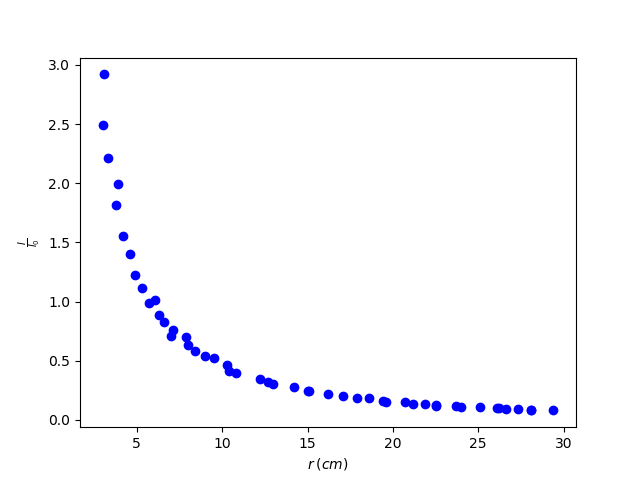

In [45]:
fig = plt.figure('Dati')
plt.xlabel(r'$r\:(cm)$')
plt.ylabel(r'$\frac{I}{I_0}$')

open_serial_comm()

for i in range(N):
    t, r, r_err, I, I_err = read_serial_data()
    rs[i], rs_err[i], Is[i], Is_err[i] = r, r_err, I, I_err
    plt.plot(r, I, 'bo')
    fig.canvas.draw()

close_serial_comm()

plt.savefig('data.png')

Riportiamo i dati acquisiti.

In [46]:
from IPython.display import display, Markdown

md_code = '|#|$r$ (cm)|$\\delta r$ (cm)|$\\frac{I}{I_0}$|$\\delta\\left(\\frac{I}{I_0}\\right)$|\n|---|---|---|---|---|\n'
for i in range(N):
    md_code += f'|{i}|{rs[i]}|{rs_err[i]}|{Is[i]}|{Is_err[i]}|\n'

display(Markdown(md_code))

|#|$r$ (cm)|$\delta r$ (cm)|$\frac{I}{I_0}$|$\delta\left(\frac{I}{I_0}\right)$|
|---|---|---|---|---|
|0|3.1|0.3|2.9195|0.015|
|1|3.0|0.3|2.4915|0.0119|
|2|3.3|0.3|2.217|0.0101|
|3|3.9|0.3|1.9912|0.0087|
|4|3.8|0.3|1.8182|0.0078|
|5|4.2|0.3|1.5511|0.0064|
|6|4.6|0.3|1.4014|0.0056|
|7|4.9|0.3|1.2239|0.0048|
|8|5.3|0.3|1.1136|0.0044|
|9|6.1|0.3|1.0098|0.0039|
|10|6.3|0.3|0.8875|0.0035|
|11|6.6|0.3|0.8235|0.0033|
|12|7.1|0.3|0.7638|0.003|
|13|7.9|0.3|0.7022|0.0028|
|14|8.0|0.3|0.6368|0.0026|
|15|8.4|0.3|0.586|0.0025|
|16|9.5|0.3|0.5246|0.0023|
|17|10.3|0.3|0.4614|0.0021|
|18|10.8|0.3|0.3995|0.0019|
|19|12.2|0.3|0.3496|0.0018|
|20|13.0|0.3|0.3048|0.0017|
|21|14.2|0.3|0.274|0.0016|
|22|15.1|0.3|0.2476|0.0015|
|23|16.2|0.3|0.2222|0.0015|
|24|17.1|0.3|0.2007|0.0014|
|25|18.6|0.3|0.1827|0.0014|
|26|19.4|0.3|0.1638|0.0013|
|27|20.7|0.3|0.1481|0.0013|
|28|21.9|0.3|0.1354|0.0013|
|29|22.5|0.3|0.1242|0.0012|
|30|23.7|0.3|0.1156|0.0012|
|31|25.1|0.3|0.1083|0.0012|
|32|26.1|0.3|0.1|0.0012|
|33|26.6|0.3|0.0941|0.0012|
|34|27.3|0.3|0.0895|0.0012|
|35|28.1|0.3|0.086|0.0012|
|36|29.4|0.3|0.0803|0.0011|
|37|28.1|0.3|0.0837|0.0011|
|38|26.2|0.3|0.0965|0.0012|
|39|24.0|0.3|0.1095|0.0012|
|40|22.5|0.3|0.1205|0.0012|
|41|21.2|0.3|0.1341|0.0013|
|42|19.6|0.3|0.1533|0.0013|
|43|17.9|0.3|0.184|0.0014|
|44|15.0|0.3|0.2415|0.0015|
|45|12.7|0.3|0.32|0.0017|
|46|10.4|0.3|0.413|0.002|
|47|9.0|0.3|0.536|0.0023|
|48|7.0|0.3|0.7078|0.0029|
|49|5.7|0.3|0.9903|0.0039|


## Analisi dati

Verifichiamo che $\frac{1}{r^2}$ e $I$ siano proporzionali.

<IPython.core.display.Javascript object>


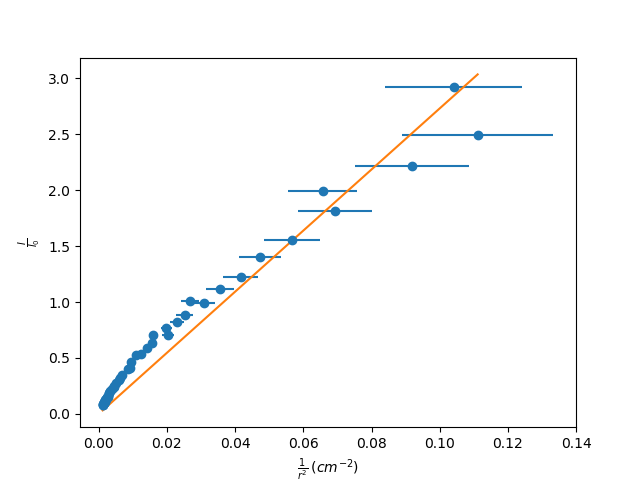

In [48]:
fig = plt.figure('Legge dell\'inverso del quadrato della distanza')
plt.xlabel(r'$\frac{1}{r^2}\:(cm^{-2})$')
plt.ylabel(r'$\frac{I}{I_0}$')

data, caplines, barlinecols = plt.errorbar(1/rs**2, Is, fmt='o', xerr=-2/rs**3*rs_err, yerr=Is_err)

k, = np.linalg.lstsq(np.stack([1/rs**2], axis=-1), Is, rcond=None)[0]
x = np.array([min(1/rs**2), max(1/rs**2)])
y = k * x
fit, = plt.plot(x, y)

plt.savefig('inverse-square-law.png')

La retta rappresenta il *best fit*. Il coefficiente angolare di tale retta corrisponde a $\frac{P}{4\pi}$.

## Conclusioni

Come si può osservare dall'ultimo grafico, la legge dell'inverso del quadrato della distanza può considerarsi verificata entro le incertezze sperimentali, dominate, specialmente alle piccole distanze, dalla scarsa sensibilità del sensore HC-SR04. Da sottolineare anche una probabile sottovalutazione dell'incertezza sulla luminosità determinata dalla scarsa documentazione della fotocella.
Altre fonti di errore che meriterebbero attenzione sono 
- il fondo luminoso, difficile da eliminare totalmente
- la precisa relazione luminosità-resistenza delle fotocelle, non ben documentata nel datasheet.